In [1]:
import sys
sys.path.append('../')

from data.data_loader import COCODataLoader
import yaml

# Load config
with open('../config/config.yaml', 'r') as f:
    config = yaml.safe_load(f)

# Initialize data loader
data_loader = COCODataLoader(config)

# Get train and validation loaders
train_loader = data_loader.get_train_loader()
val_loader = data_loader.get_val_loader()

# Get class mapping info
class_mapping = data_loader.get_class_mapping()
num_classes = data_loader.get_num_classes()

print(f"Number of classes: {num_classes}")
print(f"Class mapping: {class_mapping}")
print(f"Train batches: {len(train_loader)}")
print(f"Val batches: {len(val_loader)}")

Number of classes: 7
Class mapping: {'person': 0, 'car': 1, 'bicycle': 2, 'motorcycle': 3, 'bus': 4, 'truck': 5, 'other': 6}
Train batches: 1
Val batches: 3


In [2]:
# Iterate through a batch
for batch in train_loader:
    images = batch['images']  # Tensor of shape [batch_size, 3, H, W]
    labels = batch['labels']  # List of tensors (variable length per image)
    boxes = batch['boxes']    # List of tensors (variable length per image)
    image_ids = batch['image_ids']
    num_detections = batch['num_detections']
    
    print(f"\nBatch shape: {images.shape}")
    print(f"Number of images: {len(labels)}")
    
    # Example: Access first image's labels and boxes
    first_image_labels = labels[0]
    first_image_boxes = boxes[0]
    
    print(f"First image has {len(first_image_labels)} detections")
    print(f"Labels: {first_image_labels}")
    print(f"Boxes shape: {first_image_boxes.shape}")  # [num_detections, 4]
    
    break  # Just show first batch


Batch shape: torch.Size([15, 3, 640, 640])
Number of images: 15
First image has 1 detections
Labels: tensor([6])
Boxes shape: torch.Size([1, 4])


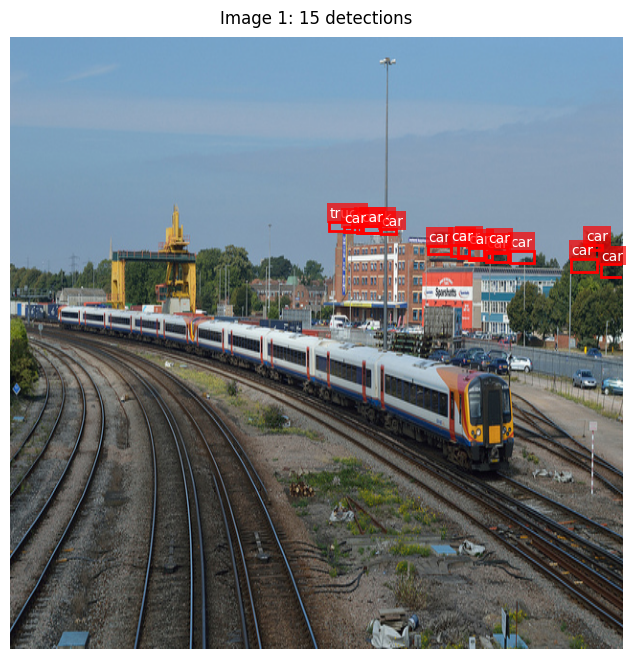

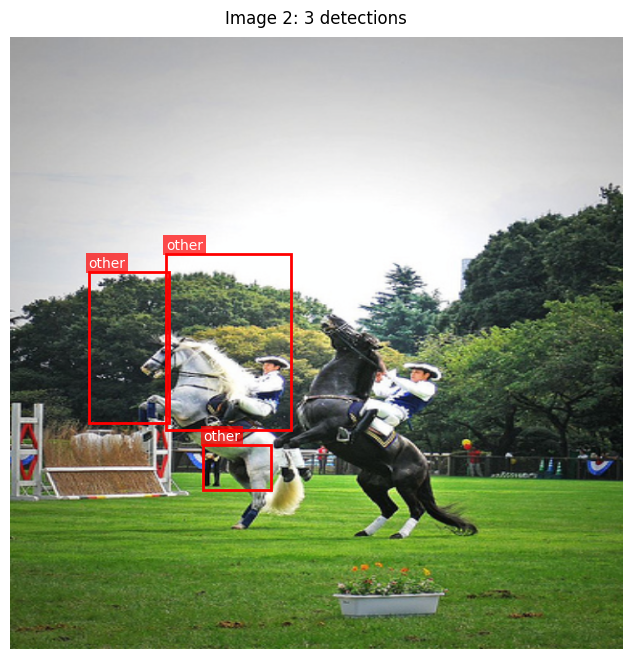

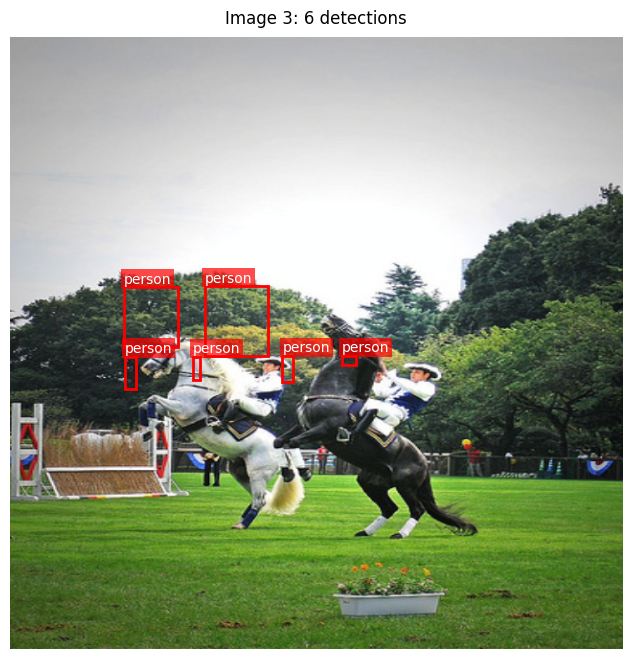

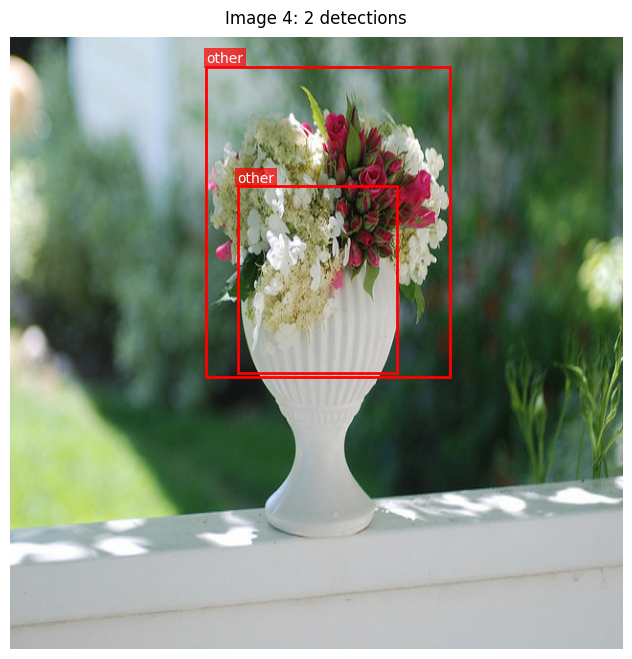

In [5]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np

def denormalize_image(image_tensor):
    """Denormalize image for visualization."""
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    
    # Convert to numpy and transpose to (H, W, C)
    img = image_tensor.cpu().numpy().transpose(1, 2, 0)
    
    # Denormalize
    img = std * img + mean
    img = np.clip(img, 0, 1)
    
    return img

def visualize_batch(batch, class_mapping, num_images=4):
    """Visualize images with bounding boxes and labels."""
    images = batch['images']
    labels = batch['labels']
    boxes = batch['boxes']
    
    # Create reverse mapping (idx to class name)
    idx_to_class = {idx: name for name, idx in class_mapping.items()}
    
    # Plot up to num_images
    num_to_plot = min(num_images, len(images))
    
    for i in range(num_to_plot):
        # Denormalize and display image
        img = denormalize_image(images[i])
        
        # Get original image dimensions
        h, w = img.shape[:2]
        
        # Create figure with exact image size (in inches, dpi=100)
        fig, ax = plt.subplots(1, 1, figsize=(w/100, h/100), dpi=100)
        
        # Display image without any scaling
        ax.imshow(img)
        
        # Get labels and boxes for this image
        img_labels = labels[i]
        img_boxes = boxes[i]
        
        # Draw bounding boxes
        for j, (label_idx, box) in enumerate(zip(img_labels, img_boxes)):
            x1, y1, x2, y2 = box.cpu().numpy()
            width = x2 - x1
            height = y2 - y1
            
            # Create rectangle
            rect = patches.Rectangle(
                (x1, y1), width, height,
                linewidth=2, edgecolor='red', facecolor='none'
            )
            ax.add_patch(rect)
            
            # Add label text
            class_name = idx_to_class.get(int(label_idx), 'unknown')
            ax.text(
                x1, y1 - 5,
                f'{class_name}',
                color='white',
                fontsize=10,
                bbox=dict(facecolor='red', alpha=0.7, edgecolor='none', pad=2)
            )
        
        ax.axis('off')
        ax.set_title(f'Image {i+1}: {len(img_labels)} detections', pad=10)
        plt.tight_layout(pad=0)
        plt.show()

# Visualize a batch from training data
for batch in train_loader:
    visualize_batch(batch, class_mapping, num_images=4)
    break